In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

In [3]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style

style.use('childsafeai')

Populating the interactive namespace from numpy and matplotlib


In [4]:
from local_settings import GOOGLE_API_KEY

gmaps.configure(GOOGLE_API_KEY) 

In [5]:
%store -r citywide_all

# NYC Hospital Beds

## Processing

In [8]:
hospital_beds = pd.read_csv('data/nyc_hospital_beds.csv')

In [9]:
hospital_beds['hospital'].nunique()

57

In [10]:
hospital_beds[hospital_beds['bed_type'] == 'Total Beds']['count'].sum()

23922

In [11]:
hospital_beds[hospital_beds['bed_type'].isin(['Intensive Care Beds', 'Pediatric ICU Beds'])]['count'].sum()

1665

In [14]:
hospital_borough_mapping = pd.read_csv('data/nyc_hospital_region_mapping.csv')

In [15]:
hospital_borough_mapping['Hospital'] = hospital_borough_mapping['Hospital'].map(lambda x: x.replace('\xa0\xa0', ''))
hospital_borough_mapping['Borough'] = hospital_borough_mapping['Borough'].map(lambda x: x.replace(' (New York Metro - New York City', '').replace(')', '').replace('; New York Metro - New York City', '').strip())

In [16]:
hospital_beds['Borough'] = None

def classify_borough(row):
    for hospital in hospital_borough_mapping.to_dict(orient='records'):
        if hospital['Hospital'] == row['hospital']:
            row['Borough'] = hospital['Borough']
            
            if row['Borough'] == 'Richmond':
                row['Borough'] = 'Staten Island'
    
    return row


hospital_beds = hospital_beds.apply(classify_borough, axis=1)

## Analysis

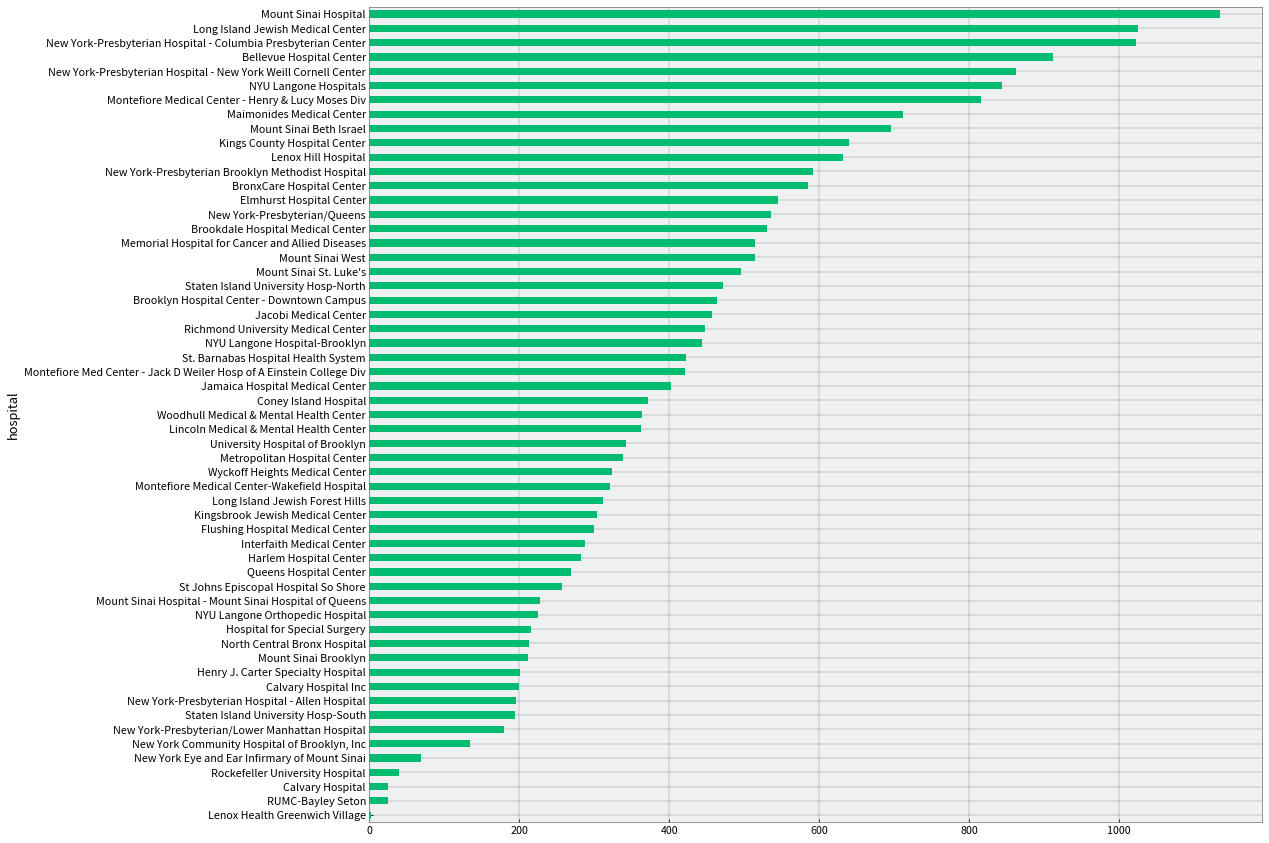

In [21]:
figsize(16,15)
hospital_beds[hospital_beds['bed_type'] == 'Total Beds'].groupby('hospital')['count'].sum().sort_values().plot(kind='barh')

In [22]:
hospital_beds['Borough'] = hospital_beds['Borough'].map(lambda x: "Brooklyn" if x == "Kings" else x)

In [23]:
hospital_beds[hospital_beds['bed_type'] == 'Total Beds'].groupby('Borough')['count'].sum().sort_values()

Borough
Staten Island    1139
Bronx            3797
Queens           3872
Brooklyn         5741
New York         9373
Name: count, dtype: int64

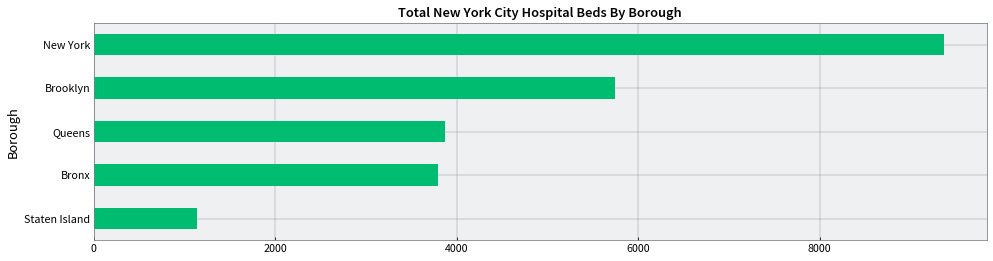

In [24]:
figsize(16, 4)
hospital_beds[hospital_beds['bed_type'] == 'Total Beds'].groupby('Borough')['count'].sum().sort_values().plot(kind='barh',
                                                                                                              title="Total New York City Hospital Beds By Borough")

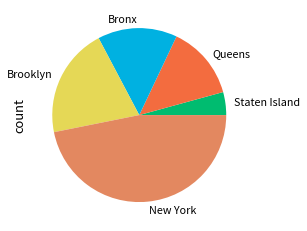

In [25]:
hospital_beds[hospital_beds['bed_type'].isin(['Intensive Care Beds', 'Pediatric ICU Beds'])].groupby('Borough')['count'].sum().sort_values().plot(kind='pie')

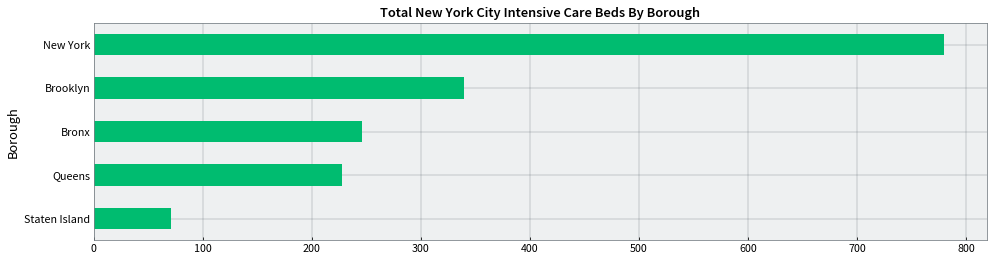

In [26]:
figsize(16, 4)
hospital_beds[hospital_beds['bed_type'].isin(['Intensive Care Beds', 'Pediatric ICU Beds'])].groupby('Borough')['count'].sum().sort_values().plot(kind='barh',
                                                                                                              title="Total New York City Intensive Care Beds By Borough")

In [27]:
figsize(16, 9)
ax = citywide_all[citywide_all['Date'] >= '2019-03-01'].groupby('Date')['Value'].sum().resample('D').sum().plot(kind='line',
                                                                                                                label="Actual",
                                                                                                                legend=True,
                                                                                                                title="45 Day Forecast of New York City ER Visits for Flu-like and Respiratory Symptoms: {0} - {1}".format(citywide_all[citywide_all['Date'] >= '2019-03-01']['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                                           fc.predicted_mean.index.max().date().strftime("%d %b %Y")))

fc.predicted_mean.plot(kind='line', color='red', label="Forecast", ax=ax, legend=True)
ax.fill_between(fc.predicted_mean.index, lower_series, upper_series, alpha=0.15)
ax.legend(loc='upper left')


NameError: name 'fc' is not defined

In [28]:
samples = []

for sample in range(100):
    sim = results.simulate(45,
                           initial_state=results.predicted_state[:, -1])
    sim.index = pd.date_range(freq='D', start='2020-03-27', periods=45)
    samples.append(sim)
    
sns.lineplot(data=samples)

NameError: name 'results' is not defined

In [ ]:
'''
figsize(16, 9)

ax = sns.lineplot(data=samples)
citywide_all[citywide_all['Date'] >= '2019-12-01'].groupby('Date')['Value'].sum().resample('D').sum().plot(kind='line',
                                                                                                                label="Actual",
                                                                                                                legend=True,
                                                                                                                ax=ax,
                                                                                                                title="45 Day Forecast of New York City ER Visits for Flu-like and Respiratory Symptoms: {0} - {1}".format(citywide_all[citywide_all['Date'] >= '2019-12-01']['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                                           fc.predicted_mean.index.max().date().strftime("%d %b %Y")))


ax.legend(loc='upper left')


In [ ]:
hospitalization_estimate = (fc.predicted_mean * 0.13)
hospitalization_estimate.iloc[:1] = 10305

In [ ]:
hospitalization_lower_series = pd.Series(conf.iloc[:, 0], hospitalization_estimate.index) * 0.13
hospitalization_upper_series = pd.Series(conf.iloc[:, 1], hospitalization_estimate.index) * 0.13
hospitalization_lower_series.iloc[:1] = 10305
hospitalization_upper_series.iloc[:1] = 10305

In [ ]:
figsize(16, 9)
ax = (citywide_all[citywide_all['Date'] >= '2020-03-03'].groupby('Date')['Value'].sum().resample('D').sum() * 0.13).cumsum().plot(kind='line',
                                                                                                                label="Actual",
                                                                                                                legend=True,
                                                                                                                title="45 Day Estimate of New York City Hospitalizations for COVID-19: {0} - {1}".format(citywide_all[citywide_all['Date'] >= '2020-03-03']['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                                           fc.predicted_mean.index.max().date().strftime("%d %b %Y")))

hospitalization_estimate.cumsum().plot(kind='line', color='red', label="Forecast", ax=ax, legend=True)
ax.fill_between(hospitalization_estimate.index, hospitalization_lower_series.cumsum(), hospitalization_upper_series.cumsum(), alpha=0.15)
ax.legend(loc='upper left')
ax.axhline(hospital_beds[hospital_beds['bed_type'] == 'Total Beds']['count'].sum(),
           linestyle='--', color='red')
ax.text("2020-03-15",
        hospital_beds[hospital_beds['bed_type'] == 'Total Beds']['count'].sum() + 600,
        "Total NYC Hospital Bed Capacity: {0}".format(hospital_beds[hospital_beds['bed_type'] == 'Total Beds']['count'].sum()))
ax.axhline(hospital_beds[hospital_beds['bed_type'] == 'Total Beds']['count'].sum() * 0.35,
           linestyle='--', color='k')
ax.text("2020-04-15",
        (hospital_beds[hospital_beds['bed_type'] == 'Total Beds']['count'].sum() * 0.35) + 600,
        "Estimated Available NYC Hospital Bed Capacity: {0:.0f}".format((hospital_beds[hospital_beds['bed_type'] == 'Total Beds']['count'].sum() * 0.35)))


In [ ]:
figsize(16, 9)
ax = ((citywide_all[citywide_all['Date'] >= '2020-03-03'].groupby('Date')['Value'].sum().resample('D').sum() * 0.13)* 0.25).cumsum().plot(kind='line',
                                                                                                                label="Actual",
                                                                                                                legend=True,
                                                                                                                title="45 Day Estimate of New York City ICU Hospitalizations for COVID-19: {0} - {1}".format(citywide_all[citywide_all['Date'] >= '2020-03-03']['Date'].min().date().strftime("%d %b %Y"),
                                                                                                                                                                                                                           fc.predicted_mean.index.max().date().strftime("%d %b %Y")))

(hospitalization_estimate.cumsum() * 0.25).plot(kind='line', color='red', label="Forecast", ax=ax, legend=True)
ax.fill_between(hospitalization_estimate.index, hospitalization_lower_series.cumsum()* 0.25, hospitalization_upper_series.cumsum()* 0.25, alpha=0.15)
ax.legend(loc='upper left')
ax.axhline(hospital_beds[hospital_beds['bed_type'].isin(['Intensive Care Beds', 'Pediatric ICU Beds'])]['count'].sum(),
           linestyle='--', color='red')
ax.text("2020-04-01",
        hospital_beds[hospital_beds['bed_type'].isin(['Intensive Care Beds', 'Pediatric ICU Beds'])]['count'].sum() + 100,
        "Total NYC ICU Hospital Bed Capacity: {0}".format(hospital_beds[hospital_beds['bed_type'].isin(['Intensive Care Beds', 'Pediatric ICU Beds'])]['count'].sum()))
ax.axhline(hospital_beds[hospital_beds['bed_type'].isin(['Intensive Care Beds', 'Pediatric ICU Beds'])]['count'].sum() * 0.35,
           linestyle='--', color='k')
ax.text("2020-04-15",
        (hospital_beds[hospital_beds['bed_type'].isin(['Intensive Care Beds', 'Pediatric ICU Beds'])]['count'].sum() * 0.35 + 100),
        "Estimated Available NYC ICU Hospital Bed Capacity: {0:.0f}".format((hospital_beds[hospital_beds['bed_type'].isin(['Intensive Care Beds', 'Pediatric ICU Beds'])]['count'].sum() * 0.35)))
()

In [ ]:
(hospitalization_lower_series * 0.25).mean()